In [2]:
import numpy as np
import cv2 as cv # opencv computer vision library
from matplotlib import pyplot as plt # ploting
from scipy.spatial.transform import Rotation

In [3]:
with open("samples/calib/00/calib.txt") as f:
    iPx = f.readlines()
# homography matrix
iP3 = np.array([float(i) for i in iPx[3].strip('\n').split(' ')[1:]]).reshape(3,4)
iP2 = np.array([float(i) for i in iPx[2].strip('\n').split(' ')[1:]]).reshape(3,4)

# transformation matrix
Tr = np.array([float(i) for i in iPx[4].strip('\n').split(' ')[1:]]).reshape(4,3)

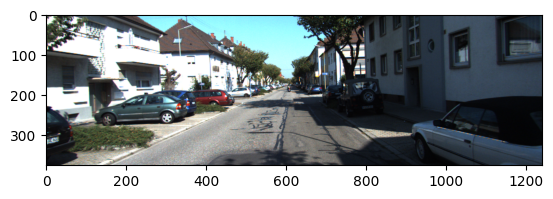

In [806]:
def imshow(image, title = '', cmap=None):
    # image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    fig = plt.figure()
    plt.imshow(image, cmap)
    plt.title(title)
    plt.savefig("output.png", dpi =500)

images = []
image_index = []
for i in range(10,10,5):
    image_index.append(i)
    images.append( cv.imread("samples/images/00/images2/00000{x}.png".format(x=i)))
for i in range(60,100,1):
    image_index.append(i)
    images.append( cv.imread("/Users/tianyang/DATASET/KITTI/dataset/sequences/00/image_2/0000{x}.png".format(x=i)))
for i in range(100,400,1):
    image_index.append(i)
    images.append( cv.imread("/Users/tianyang/DATASET/KITTI/dataset/sequences/00/image_2/000{x}.png".format(x=i)))

ioo = cv.cvtColor(images[0], cv.COLOR_BGR2RGB)
imshow(ioo)
H,W,d = images[0].shape

In [807]:
# instrincs of cams
K2 = iP2[:3,:3]
K3 = iP3[:3,:3]

# calculate real translation
K2_inv = np.linalg.inv(K2)
K3_inv = np.linalg.inv(K3)
T2 = K2_inv@(iP2[:3,3].reshape(3,1))
T3 = K3_inv@(iP3[:3,3].reshape(3,1))

f = K2[0,0]
K = np.array([[f,0,W/2],[0,f,H/2],[0,0,1]])
r=40
M = np.array([[1/r,0,-W/(2*r)],[0,1/r,-H/(r*2)],[0,0,0],[0,0,1]])
R = np.array([[1,0,0,0],[0,0,1,0],[0,-1,0,0],[0,0,0,1]])
dy = 1.65
dz = 10
T = np.array([[1,0,0,0],[0,1,0,dy],[0,0,1,dz],[0,0,0,1]])
Io = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

My = (K @ Io) @ ((T @ R ) @ M)

My_inv = np.linalg.inv(My)

In [808]:
def project_show(img):
    warped_img = cv.warpPerspective(img, My_inv, (W, H)) # Image warping
    imshow(warped_img,i)

def process(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img[0:330,400:800,:3]

def project(img):
    return cv.warpPerspective(img, My_inv, (W, H)) # Image warping


In [809]:
with open('samples/poses/00.txt') as f:
    pose_txt = f.readlines()
# homography matrix

poses = []
R, T, Tx, Ty = [], [], [], []
for j in image_index:
    pose = np.array([float(i) for i in pose_txt[j].strip('\n').split(' ')]).reshape(3,4)
    poses.append(pose)
    R.append(pose[:3,:3])
    T.append(pose[:3,3:4])
    Tx.append(pose[0][3])
    Ty.append(pose[2][3])


In [810]:
def rotate(image, alpha_y):
    height, width = image.shape[:2]
    # get the center coordinates of the image to create the 2D rotation matrix
    center = (width/2, height/2)
    # using cv2.getRotationMatrix2D() to get the rotation matrix
    rotate_matrix = cv.getRotationMatrix2D(center=center, angle=alpha_y, scale=1)

    # rotate the image using cv2.warpAffine
    return cv.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

In [811]:
def project_rotate(img, my_map, center_y, center_x, alpha_z):
    img = rotate(process(project(img)),alpha_z)
    h,w,d = img.shape
    # my_map[center_x:center_x+h,center_y:center_y+w,:] = img
    for x in range(h):
        for y in range(w):
            if np.sum(img[x][y]) > 1:
                my_map[center_x+x, center_y+y] = img[x][y]
    return my_map

In [813]:
def compose_graphs(imgs, alphas, Tx, Ty, start_x, start_y, scale_x, scale_y ,
                  newgraph_size = (6000,6000,3), intercept = 1):

    new_map = np.zeros(newgraph_size)
    for i in range(len(images)):
        new_map = project_rotate(imgs[i], new_map, int((Tx[i]+np.sin(-alphas[i]/180*np.pi)*intercept)*scale_x+start_y),
                                 int(-(Ty[i]-np.cos(-alphas[i]/180*np.pi)*intercept)*scale_y+start_x), -alphas[i])

    return new_map.astype('int')


In [825]:
# alpha = Rotation.from_matrix(R).as_euler('zyx', degrees=True)
alpha = [Rotation.from_matrix(r).as_euler('xyz',degrees=True)[1] for r in R]
newgraph = compose_graphs(images, alpha, Tx, Ty, 6000, 800, 48, 25, intercept=-13)  # -11

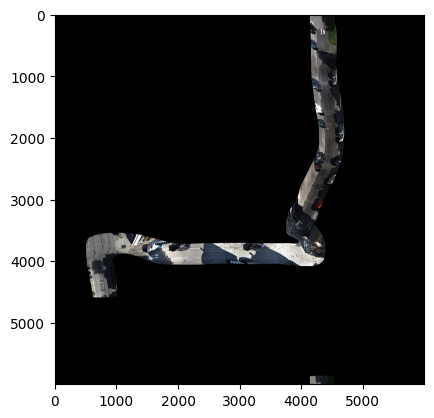

In [826]:
imshow(newgraph) # compose_graphs(images, alpha, Tx, Ty, 4800, -2500, 50, 25, intercept=-10)  # -11

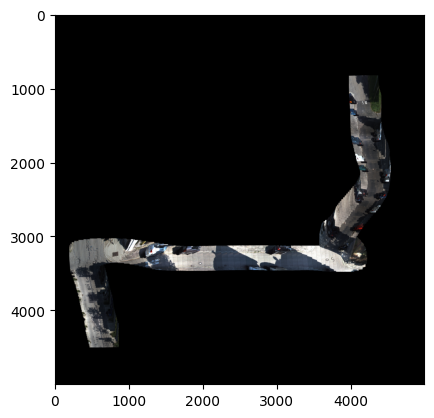

<Figure size 640x480 with 0 Axes>

In [760]:
imshow(newgraph) # compose_graphs(images, alpha, Tx, Ty, 4500, 500, 50, 15, intercept=-13)  # -11

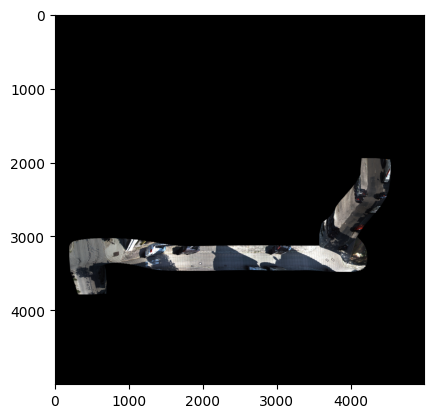

In [745]:
imshow(newgraph) #  compose_graphs(images, alpha, Tx, Ty, 4500, 500, 50, 25, intercept=-13)  # -11

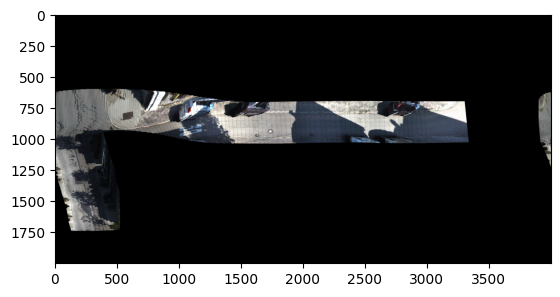

In [710]:
imshow(newgraph) # (images, alpha, Tx, Ty, 2400, 500, 49, 20, intercept=-10)